# Logistic Regression MNIST

In [28]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models

from tensorflow.keras.models import Model
from scipy.ndimage import zoom

import tensorflow as tf
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.stats import chi2

##### Here follows some exploratory analysis on MNIST data

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0 ) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

In [6]:
x_train.shape

(12665, 28, 28)

In [7]:
x_test.shape

(2115, 28, 28)

In [8]:
len(y_test) / (len(y_train) + len(y_test))

0.14309878213802435

In [9]:
x_train[0].shape

(28, 28)

In [10]:
zero = len(np.where(y_train == 0)[0])
one = len(np.where(y_train == 1)[0])
print(zero, one)

5923 6742


In [11]:
zero = len(np.where(y_test == 0)[0])
one = len(np.where(y_test == 1)[0])
print(zero, one)

980 1135


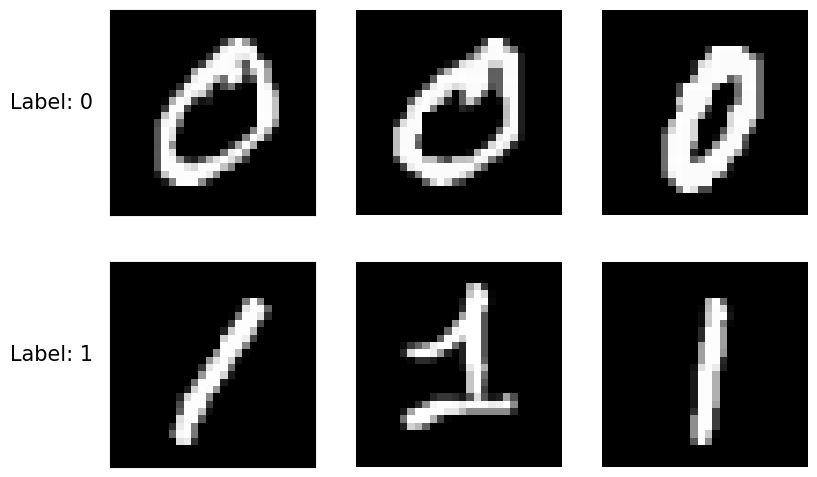

In [17]:
# plot some samples of the MNIST dataset
index_of_0 = np.where(y_train == 0)[0][:3]
index_of_1 = np.where(y_train == 1)[0][4:8]

plt.figure(figsize=(9,6))

plt.subplot(2, 3, 1)
plt.imshow(x_train[index_of_0[0]], cmap='gray')
# plt.axis('off')
plt.ylabel('Label: 0', fontsize=15, rotation=0, labelpad=42)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 2)
plt.imshow(x_train[index_of_0[1]], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(x_train[index_of_0[2]], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(x_train[index_of_1[0]], cmap='gray')
# plt.axis('off')
plt.ylabel('Label: 1', fontsize=15, rotation=0, labelpad=42)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 5)
plt.imshow(x_train[index_of_1[1]], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(x_train[index_of_1[2]], cmap='gray')
plt.axis('off')
plt.savefig('../Figures/mnist_samples.png', dpi=400, bbox_inches='tight')
plt.show()



In [13]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

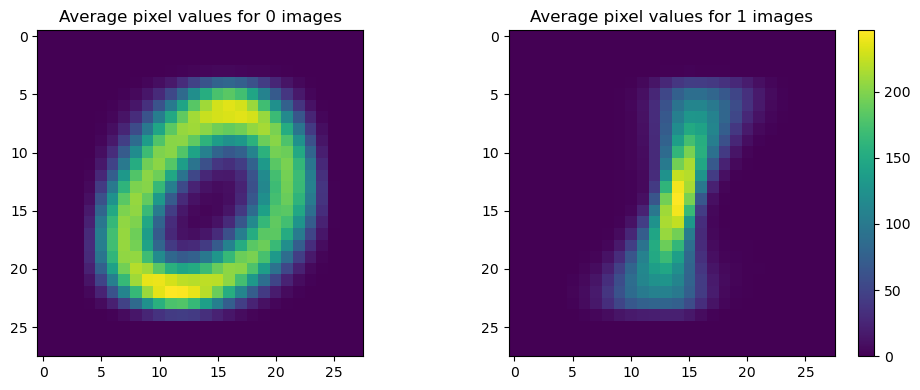

In [14]:
# this cell is to calculate and plot the average 0 and 1 image in the
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

zero_filter = np.where(y_train == 0 )
one_filter = np.where(y_train == 1)

x_zero  = x_train[zero_filter]
x_one = x_train[one_filter]

x_zero_flat = x_zero.reshape(x_zero.shape[0], -1)
x_one_flat = x_one.reshape(x_one.shape[0], -1)

end_zero = np.zeros(784)
end_one = np.zeros(784)

for i in range(0, x_zero_flat.shape[0]):
    end_zero += x_zero_flat[i]
for i in range(0, x_one_flat.shape[0]):
    end_one += x_one_flat[i]

end_zero = end_zero / (x_zero.shape[0])
end_one = end_one / (x_one.shape[0])

end_zero = end_zero.reshape(28,28)
end_one = end_one.reshape(28,28)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1) 
plt.imshow(end_zero, cmap='viridis', interpolation='nearest')
plt.title("Average pixel values for 0 images")
# plt.colorbar()

plt.subplot(1, 2, 2) 
plt.imshow(end_one, cmap='viridis', interpolation='nearest')
plt.title("Average pixel values for 1 images")
plt.colorbar()

plt.tight_layout()
# plt.savefig('../Figures/lr-coeff-visual.png', dpi=400, bbox_inches='tight')
plt.show()

In [18]:
# load MNIST data and filter out 0's and 1's 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0 ) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# flatten the 28x28 images to a 784 vector
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# scale to data
scaler = StandardScaler()
x_train_flat_scaled = scaler.fit_transform(x_train_flat)
x_test_flat_scaled = scaler.transform(x_test_flat)

# no regularization, hence C=1. Also intialize logistic regression with SAGA
C_value = 1
logistic = LogisticRegression(penalty=None, C=C_value, solver='saga', max_iter=10000, random_state=0)

# fit the model and predict the binary outcomes
logistic.fit(x_train_flat_scaled, y_train)
y_pred_prob = logistic.predict_proba(x_test_flat_scaled)[:, 1]  
y_pred_binary = np.where(y_pred_prob > 0.5, 1, 0)

# calculate accuracy 
accuracy = np.mean(y_pred_binary == y_test)

coefficients = logistic.coef_

# calculate the log likelihood of the full model
log_likelihood_model = -log_loss(y_train, logistic.predict_proba(x_train_flat_scaled), normalize=False)

# fit the null model without any regressors and calculate log likelihood
null_model = LogisticRegression(penalty=None, C=C_value, solver='saga', max_iter=10000)
null_model.fit(np.ones((x_train_flat_scaled.shape[0], 1)), y_train)
log_likelihood_null = -log_loss(y_train, null_model.predict_proba(np.ones((x_train_flat_scaled.shape[0], 1))), normalize=False)

# calculate pseudo-R^2, lrt, and p-value
pseudo_r_squared = 1 - (log_likelihood_model / log_likelihood_null)
ltr = -2 * (log_likelihood_null - log_likelihood_model)

df = x_train_flat_scaled.shape[1]
p_value = chi2.sf(ltr, df)

print(f"McFadden's Pseudo R-squared: {pseudo_r_squared}")
print(f"Likelihood ratio test statistic: {ltr}")
print(f"p-value: {p_value}")
print(f'Accuracy: {accuracy}')

McFadden's Pseudo R-squared: 0.9994740191128348
Likelihood ratio test statistic: 17495.212336609788
p-value: 0.0
Accuracy: 0.9995271867612293


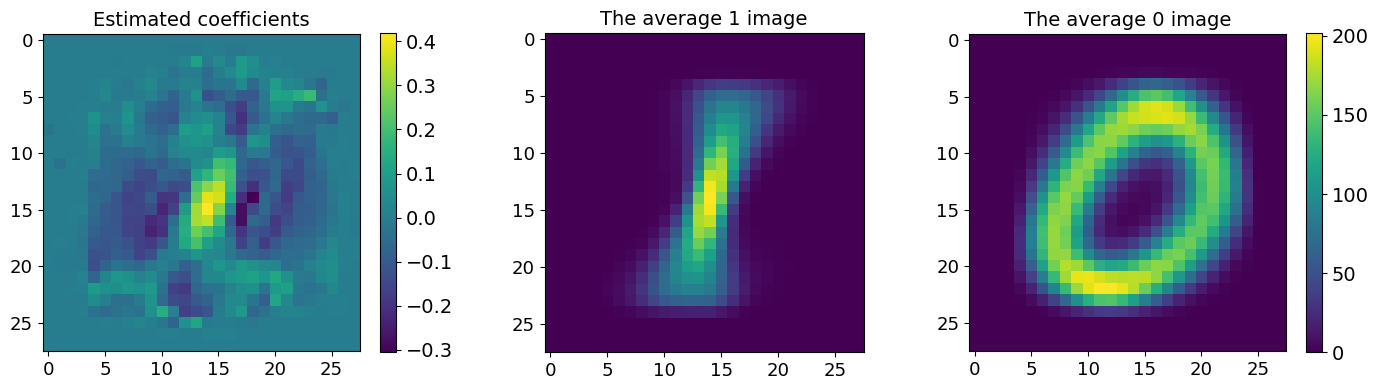

In [19]:
# plot the estimated coefficients next to average 0 and 1 image
params = coefficients.reshape(28, 28)

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 3) 
plt.imshow(end_zero, cmap='viridis', interpolation='nearest')
plt.title("The average 0 image", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.subplot(1, 3, 2) 
plt.imshow(end_one, cmap='viridis', interpolation='nearest')
plt.title("The average 1 image", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


plt.subplot(1,3,1)
plt.imshow(params, cmap='viridis', interpolation='nearest')
plt.title("Estimated coefficients", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.tight_layout()
# plt.savefig('../Figures/logreg-coeff-visual.png', dpi=400, bbox_inches='tight')
plt.show()

# CNN MNIST

In [21]:
# load MNIST data and scale to [0,1]
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0 ) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

x_train = x_train / 255
x_test = x_test / 255

In [22]:
# one-hot encode the responses to [0,1] and [1,0]
y_cat_test = to_categorical(y_test, num_classes=2)
y_cat_train = to_categorical(y_train, num_classes=2)

y_cat_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [23]:
x_train.shape

(12665, 28, 28)

In [24]:
x_test.shape

(2115, 28, 28)

In [25]:
# last step is to reshape the data because we need to let the network know we are only dealing with one color channel
# sample_size, width, height, color_channels
x_train = x_train.reshape(12665,28,28,1)
x_test = x_test.reshape(2115,28,28,1)

In [26]:
# build to CNN model using:
# 1. Convolutional layer with 32 kernels, kernel size 4x4, valid padding, and relu activation
# 2. Max pooling layer with filter size 2x2
# 3. Flatten output
# 4. Add two fully connected layers with relu and softmax activation
# 5. compile the model use categorical crossentropy and adam optimization
# 6. implement early stopping, use 10 epochs
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(4,4),
                 strides=(1,1), #default
                 padding='valid', #default
                 input_shape=(28,28,1),
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True)

history =model.fit(x=x_train,
          y=y_cat_train,
          epochs=10,
          validation_data=(x_test, y_cat_test),
          callbacks=[early_stop])

Epoch 1/10


2024-03-29 13:18:48.027500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


396/396 [==============================] - 25s 58ms/step - loss: 0.0099 - accuracy: 0.9961 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 2/10
396/396 [==============================] - 21s 53ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 3/10
396/396 [==============================] - 21s 53ms/step - loss: 9.3949e-04 - accuracy: 0.9997 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 4/10
396/396 [==============================] - 21s 53ms/step - loss: 5.9650e-04 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 5/10
396/396 [==============================] - 21s 53ms/step - loss: 8.5541e-04 - accuracy: 0.9998 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 6/10
396/396 [==============================] - 21s 54ms/step - loss: 4.5839e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9991


In [188]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               589952    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 590754 (2.25 MB)
Trainable params: 590754 (2.25 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

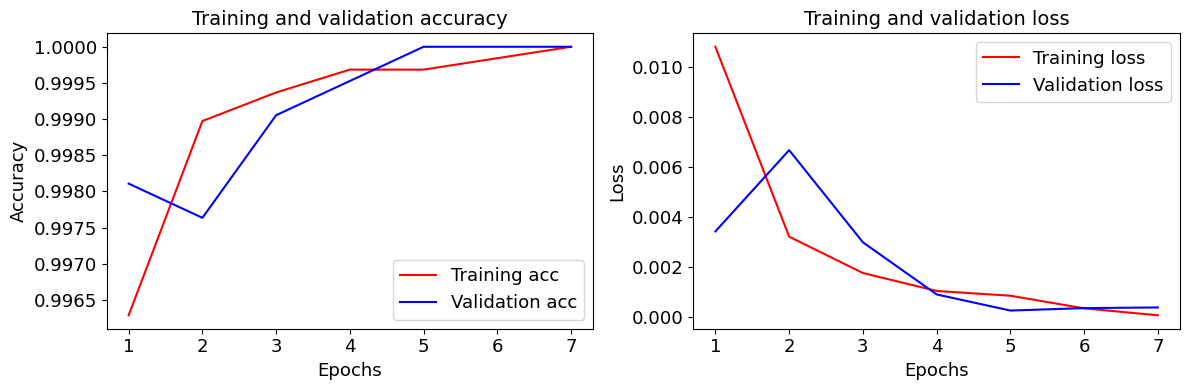

In [175]:
# plot the accuracy, validation accuracy, loss, and validation loss during training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) 
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

plt.subplot(1, 2, 2) 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=14)
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

plt.tight_layout()
plt.show()

In [176]:
# calculate the accuracy and loss on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_cat_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.0002473361964803189
Test Accuracy: 1.0


# Visualization intermediate activation maps

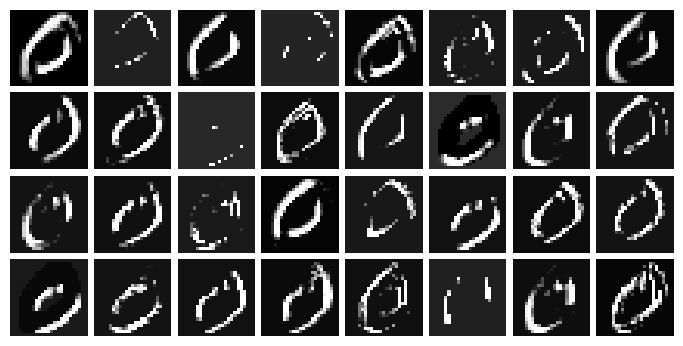

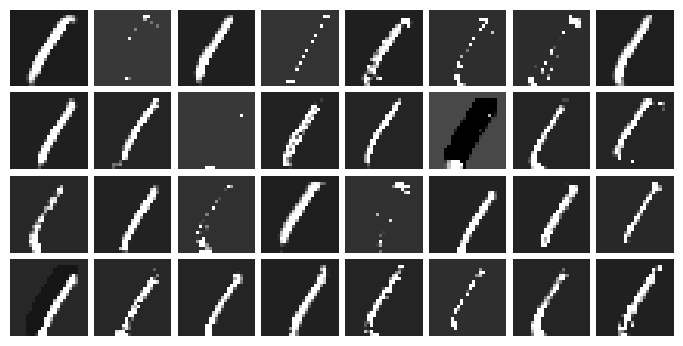

In [186]:
# define images per row in end plot. initialize list of two images from MNIST dataset
# to show activation maps for. create list of conv layer names to show maps for
images_per_row = 8
img_tensor_list = [x_train[0].reshape(1, 28, 28, 1), x_train[1].reshape(1, 28, 28, 1)]
mnist_model = model
layer_names = [layer.name for layer in mnist_model.layers if 'conv' in layer.name]

# alter the cnn model to only give the output of the conv layers defined in layer_names
activation_model = models.Model(inputs=mnist_model.input, outputs=[mnist_model.get_layer(name).output for name in layer_names])
count = 0

# space between act maps in end plot
space_between = 2  

# iterate over the two MNIST images
for img_tensor in img_tensor_list:

    # get activation maps of the model
    activations = activation_model.predict(img_tensor, verbose=0)

    # iterate over each conv layer and its activation map
    for layer_name, layer_activation in zip(layer_names, activations):

        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row

        # initialize display_grid with ones (white background) for end plot
        display_grid = np.ones(((size + space_between) * n_cols - space_between,
                                 (size + space_between) * images_per_row - space_between)) * 255

        # iterate over each position (channel) in the display grid to fill it with the activation maps
        for column in range(n_cols):
            for row in range(images_per_row):
                chnl_ind = column * images_per_row + row
                if chnl_ind >= n_features:
                    break
                
                # extract and normalize the activation map for the currect position of the display grid 
                chnl_img = layer_activation[:, :, chnl_ind]
                chnl_img -= chnl_img.mean()
                chnl_img /= chnl_img.std() + 1e-5
                chnl_img *= 64
                chnl_img += 128
                chnl_img = np.clip(chnl_img, 0, 255).astype('uint8')

                # place the activation map in to display grid
                col_start = (column * (size + space_between))
                col_end = col_start + size
                row_start = (row * (size + space_between))
                row_end = row_start + size
                
                display_grid[col_start: col_end, row_start: row_end] = chnl_img

        # plot the full grid with activation maps
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.axis('off')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
        # plt.savefig(f'../Figures/activationmaps_{count}.png', dpi=400, bbox_inches='tight')
        plt.show()
        count += 1

# Visualizing kernels

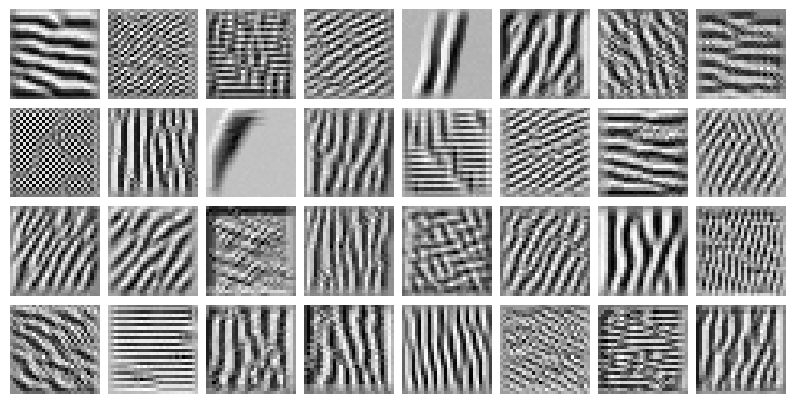

In [32]:
def deprocess_image(image):

    """
    resulting kernel image might be a tensor with shapes and integers not within the [0,255] range.
    Hence, we need to postprocess the tensor into a displayable image
    """

    image -= image.mean()
    image /= (image.std() + 1e-5)
    image *= 0.1
    image += 0.5
    image = np.clip(image, 0, 1)
    image *= 255
    image = np.clip(image, 0, 255).astype('uint8')

    return image

def generate_pattern(input_img_data, layer_name, filter_index, step=1.0, num_steps=200):
    """
    Creates the kernels for an input image at a certain layer with step size 1 over 200 iterations.
    """

    # create a model that outputs the activations of the specified layer
    intermediate_model = tf.keras.models.Model(inputs=mnist_model.input, outputs=mnist_model.get_layer(layer_name).output)

    # initialize the gradient descent to alter the input image to get responsiveness of the kernels
    for i in range(num_steps):
        with tf.GradientTape() as tape:
            # ensure tape is watching the input image tensor
            tape.watch(input_img_data)
            # forward pass to get the activations of the specified layer
            activations = intermediate_model(input_img_data)
            loss = tf.reduce_mean(activations[:, :, :, filter_index])

        # compute gradients of loss wrt to input image 
        grads = tape.gradient(loss, input_img_data)

        # normalize the gradients to help smoothness and stability of gradient descent
        grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        
        # apply the gradients to the input image
        input_img_data += grads * step

    # the final processed image is deprocessed here
    img = input_img_data[0].numpy()
    return deprocess_image(img)

# define the model and for which layer to compute kernels 
mnist_model = model
layer_name = 'conv2d'
margin = 5

# initialize process with random image
input_img_data_list = [tf.convert_to_tensor(np.random.random((1, 28, 28)) * 20)]
number = 0

# create the kernels and plot
for input_img_data in input_img_data_list:
    fig = plt.figure(figsize=(10, 5))
    # fig.suptitle(f'Filters Activation for "{number}" image', fontsize=14)

    gs = gridspec.GridSpec(4, 8, wspace=0.1, hspace=0.1)

    filter_index = 0 
    for i in range(4):
        for j in range(8): 
            filter_img = generate_pattern(input_img_data, layer_name, filter_index)
            filter_img_2d = np.squeeze(filter_img)

            ax = plt.subplot(gs[i, j])
            ax.imshow(filter_img_2d, cmap='gray')
            ax.axis('off')

            filter_index += 1

    # plt.savefig(f'../Figures/kernels_max.png', dpi=400, bbox_inches='tight')
    plt.show()
    number+=1

# Visualizing heatmaps of class activation

In [ ]:
# load the trained model, specificy name of last conv layer in model
# get output of that last layer
mnist_model = load_model('../Models_mnist/mnist_cnn.keras')
last_conv_layer_name = 'conv2d'
last_conv_layer = mnist_model.get_layer(last_conv_layer_name)
model_with_conv_output = Model(inputs=mnist_model.input, 
                               outputs=(mnist_model.layers[-1].output, last_conv_layer.output))

# chose some MNIST images to show CAMs for
index_of_0 = np.where(y_test == 0)[0][:3]
index_of_1 = np.where(y_test == 1)[0][10:14]

def generate_cam(image):
    """
    function that generates the class activation mapping for an image
    """

    # process the MNIST image to match the input shape and scale
    mnist_image = image.reshape(1, 28, 28, 1) 

    # using GradientTape to compute the gradients
    with tf.GradientTape() as tape:

        # cast the input image to a float tensor and watch it
        inputs = tf.cast(mnist_image, tf.float32)
        tape.watch(inputs)
        # forward pass: compute the predictions and the last conv layer's output
        predictions, last_conv_output = model_with_conv_output(inputs)
        # use the predicted class
        predicted_class = tf.argmax(predictions[0])
        predicted_class_output = predictions[:, predicted_class]

    # compute the gradients of the top predicted class with respect to the activation maps
    grads = tape.gradient(predicted_class_output, last_conv_output)

    # pool the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each channel in the acitvation map by the gradient, then average over the channels
    last_conv_output = last_conv_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
        last_conv_output[:, :, i] *= pooled_grads[i].numpy()
    heatmap = np.mean(last_conv_output, axis=-1)

    # normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # reduce image dimensions of original image
    original_img = mnist_image[0, :, :, 0]

    # resize the heatmap to same size of original image
    heatmap_size = original_img.shape[0]
    heatmap_resized = zoom(heatmap, (heatmap_size / heatmap.shape[0], heatmap_size / heatmap.shape[1]), order=1)
    colored_heatmap = plt.cm.jet(heatmap_resized)[:, :, :3]  # Get only the color channels

    # superimpose the heatmap onto original image
    superimposed_img = colored_heatmap * 0.4 + original_img.reshape((28, 28, 1))

    # normalize the superimposed image to display it properly
    superimposed_img = np.clip(superimposed_img / superimposed_img.max(), 0, 1)

    return superimposed_img

# generate the 6 CAMs
cam1 = generate_cam(image=x_test[index_of_0[0]])
cam2 = generate_cam(image=x_test[index_of_0[1]])
cam3 = generate_cam(image=x_test[index_of_0[2]])

cam4 = generate_cam(image=x_test[index_of_1[0]])
cam5 = generate_cam(image=x_test[index_of_1[1]])
cam6 = generate_cam(image=x_test[index_of_1[2]])


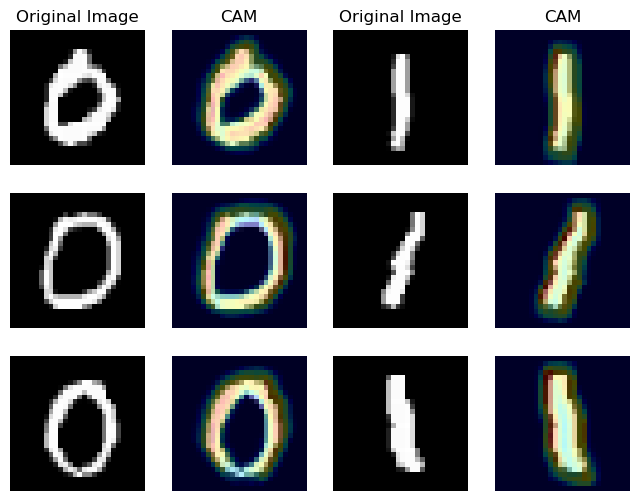

In [8]:
# plot the 6 CAMs next to their original image
plt.figure(figsize=(8,6))

plt.subplot(3, 4, 1)
plt.imshow(x_test[index_of_0[0]], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(cam1)
plt.title('CAM')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(x_test[index_of_1[0]], cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(3, 4, 4)
plt.imshow(cam4)
plt.axis('off')
plt.title('CAM')

plt.subplot(3, 4, 5)
plt.imshow(x_test[index_of_0[1]], cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(cam2)
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(x_test[index_of_1[1]], cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(cam5)
plt.axis('off')

plt.subplot(3, 4, 9)
plt.imshow(x_test[index_of_0[2]], cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(cam3)
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(x_test[index_of_1[2]], cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 12)
plt.imshow(cam6, cmap='gray')
plt.axis('off')

plt.savefig('../Figures/mnist_cams.png', dpi=400, bbox_inches='tight')
plt.show()